# 하이퍼 파라미터 목록 생성

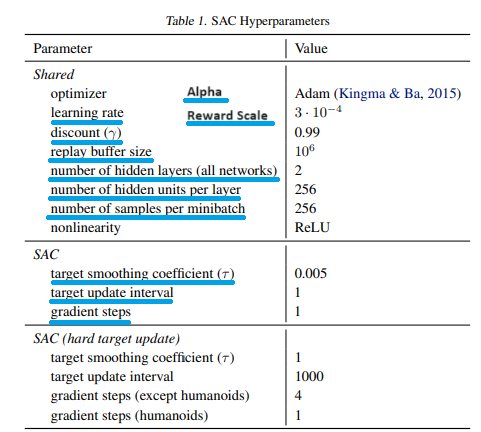

In [ ]:
hyperparameter_list = ['learning_rate','gamma','buffer_size','hidden_layers','hidden_units','samples_per_minibatch','tau_actor','tau_critic','target_update_interval','gradient_steps','alpha','reward_scale']

In [ ]:
import numpy
import pandas

hyperparameter_series = pandas.Series(hyperparameter_list)
hyperparameter_series

0              learning_rate
1                      gamma
2                buffer_size
3              hidden_layers
4               hidden_units
5      samples_per_minibatch
6                  tau_actor
7                 tau_critic
8     target_update_interval
9             gradient_steps
10                     alpha
11              reward_scale
dtype: object

In [ ]:
import json
import datetime
import pytz

def get_file_name():
    now = datetime.datetime.now(datetime.timezone.utc).astimezone(pytz.timezone('Asia/Seoul'))
    file_name = now.strftime('%y%m%d_%H%M%S')
    return file_name

class Hyperparameter:
    def __init__(self):
        # 하이퍼 파라미터 키 목록과 초기 값
        self.hyperparameter_defaults = {
            'learning_rate': 3e-4,
            'gamma': 0.99,
            'buffer_size': 1e6,
            'hidden_layers': 2,
            'hidden_units': 256,
            'samples_per_minibatch': 256,
            'tau_actor': 0.005,
            'tau_critic': 0.005,
            'target_update_interval': 1,
            'gradient_steps': 1,
            'alpha': 1,
            'reward_scale': 1,
            'env': 'ant-v1',
            'seed': 1,
            'steps': 200
        }

        self.hyperparameters = self.hyperparameter_defaults.copy()

    def save_hyperparameters(self, file_name):
        print(self.hyperparameters)
        file_path = f'hyperparameters/{file_name}.json'
        with open(file_path, 'w') as json_file:
            json.dump(self.hyperparameters, json_file, indent=4)
        print(f"하이퍼 파라미터가 {file_path}에 저장되었습니다.")

    def read_hyperparameters(self, file_name):
        file_path = f'hyperparameters/{file_name}.json'
        try:
            with open(file_path, 'r') as json_file:
                loaded_params = json.load(json_file)
            # 파일에서 읽은 값으로 업데이트하고, 없는 값은 기본 값으로 초기화
            self.hyperparameters = {**self.hyperparameter_defaults, **loaded_params}
        except FileNotFoundError:
            print(f"파일을 찾을 수 없습니다: {file_path}")
            self.hyperparameters = self.hyperparameter_defaults.copy()

        print(self.hyperparameters)

- 데이터들을 쉽게 관리할 수 있는 프로그램 짜기
- 실험 계획을 쉽게 세울 수 있는 user interface 짜기
- 가장 좋은 하이퍼 파라미터에 대해서 시각화 해주는 코드 짜기

- 시간/보상평균 을 하이퍼 파라미터에 대해 각각 저장해야함
- 각 실험의 이름은 2407날짜 이렇게 되야

# 가장 좋은 하이퍼 파라미터 찾기


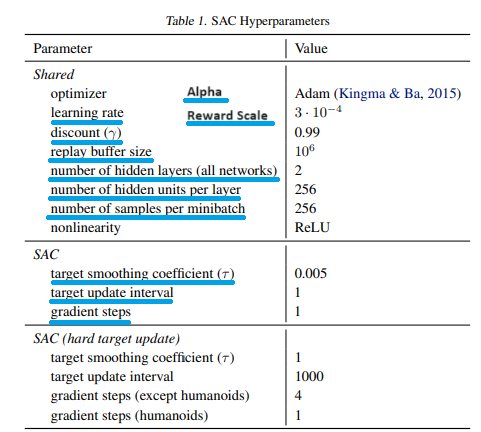

- learing rate 5 10-5 3 10-4
- gamma 0.95 0.99 0.999
- replay buffer size 1 10^6
- number of hidden layers 2 4
- number of hidden units per layer 256
- tau_actor 0.001 0.01
- tau_critic 0.001& 0.01&
- Alpha 0.5 1
- Reward Scale 1 3 10 30

2일간 하이퍼 파라미터/2일간 실험
48시간  4개 동시에 돌리기

In [ ]:
a=2*3*1*2*1*2*2*4
print(a,48/5*200/a)

192 10.0


In [ ]:
# prompt: - learing rate 5 10-5 3 10-4
# - gamma 0.95 0.99 0.999
# - replay buffer size 1 10^6
# - number of hidden layers 2 4
# - number of hidden units per layer 256
# - tau_actor 0.001 0.01
# - tau_critic 0.001& 0.01&
# - Alpha 0.5 1
# - Reward Scale 1 3 10 30
# 이것들의 itertool에서 product를 만들고 개수를세줘

from itertools import product
params = list(product([5e-5, 3e-4], [0.95, 0.99, 0.999], [1e6], [2, 4], [256], [0.001, 0.01], [0.5, 1], [1, 3, 10, 30]))
num_params = len(params)
print(num_params, 48 / 5 * 200 / num_params)
print(params[0])

192 10.0
(5e-05, 0.95, 1000000.0, 2, 256, 0.001, 0.5, 1)
5e-05


In [ ]:
param_names = ['learning_rate','gamma','replay_buffer_size','num_hidden_layers','num_hidden_units','tau','alpha','reward_scale']
param_dicts = []
for param in params:
    param_dict = dict(zip(param_names, param))
    param_dicts.append(param_dict)
print(param_dicts[0])

{'learning_rate': 5e-05, 'gamma': 0.95, 'replay_buffer_size': 1000000.0, 'num_hidden_layers': 2, 'num_hidden_units': 256, 'tau': 0.001, 'alpha': 0.5, 'reward_scale': 1}


In [ ]:
import pickle

with open('params.pkl', 'wb') as f:
    pickle.dump(param_dicts, f)
with open('params.pkl', 'rb') as f:
    params = pickle.load(f)

In [ ]:
print(len(params))

192


In [ ]:
# prompt: 변수 여러개의 초반 셋팅을 진행하는데 dict에 key가 있으면 그 value로 하이퍼 파라미터를 설정하고 없으면 그냥 기본 값으로 셋팅

default_params = {
    'learning_rate': 5e-5,
    'gamma': 0.99,
    'replay_buffer_size': 1e6,
    'num_hidden_layers': 2,
    'num_hidden_units': 256,
    'tau': 0.001,
    'alpha': 0.5,
    'reward_scale': 1
}

def set_hyperparameters(params):
    for key, value in params.items():
        if key in default_params:
            default_params[key] = value
    return default_params

# Example usage:
custom_params = {'learning_rate': 3e-4, 'gamma': 0.95}
hyperparameters = set_hyperparameters(custom_params)
print(hyperparameters)


In [ ]:
실제 실험 500 -> 12시간 각각

# 결과 시각화

In [ ]:
import pickle
with open('param_find_result.pkl', 'rb') as f:
    results = pickle.load(f)
results

[[[-154.16371569605505,
   -385.1965957675799,
   -509.64539037157994,
   -343.74357276958364,
   -321.61380510192635,
   -404.5243082300978,
   -418.8507910391785,
   -340.93526581249,
   -355.8848391192895,
   -335.04783896232925],
  [1720092044.127525,
   1720092194.3645577,
   1720092358.8773072,
   1720092518.613769,
   1720092674.8379097,
   1720092820.1887803,
   1720092963.8320045,
   1720093108.2423372,
   1720093253.2728782,
   1720093398.2550256]],
 [[-414.65318113445977,
   -348.0147788488486,
   -194.33300541699518,
   -276.7824482174524,
   -228.3127723906746,
   -237.76114997491499,
   -179.04751336875822,
   -381.98356200518316,
   -358.853481016478,
   -416.2052404832718],
  [1720093408.9394383,
   1720093548.90038,
   1720093688.600561,
   1720093827.0680003,
   1720093968.2756763,
   1720094108.053409,
   1720094248.055858,
   1720094387.7513971,
   1720094528.2276404,
   1720094667.2568338]],
 [[-214.95758587724538,
   -498.60356343792864,
   -377.3270938729897,
   

In [ ]:
len(results)

86

In [ ]:
# prompt: results는 [reward_list,time_list]로 되어 있는데 선형회귀 하여 시간당 reward의 증가값이 큰 최대 5개의 인덱스를 제시하는 코드

import numpy as np
from sklearn.linear_model import LinearRegression

# Extract reward lists and time lists from results
reward_lists = [result[0] for result in results]
time_lists = [result[1] for result in results]

# Calculate the slopes of the reward curves
slopes = []
for i in range(len(reward_lists)):
    X = np.array(time_lists[i]).reshape(-1, 1)
    y = np.array(reward_lists[i])
    model = LinearRegression().fit(X, y)
    slopes.append(model.coef_[0])
    print(slopes[-1])

# Find the indices of the top 5 slopes
top_5_indices = np.argsort(slopes)[-1:-6:-1]

# Print the top 5 indices
print("Top 5 indices with the highest reward increase per time:")
print(top_5_indices)


-0.03720935504588538
-0.03227072125356558
0.120795184191914
0.0948959339505269
0.05462775045833817
0.14458821867076474
0.16842682309033152
0.1417318767493895
-0.13723587129220846
-0.0717004922701431
-0.08878049345637293
0.2771548985125089
-0.03336939679957789
-0.06419853722879497
-0.11673346657014738
0.050283578601374064
0.06043826795743931
-0.030544711329372632
0.09454093557894372
0.2503587694772214
0.04553701305443657
0.002448384868457809
0.150014513154234
0.12433077634031778
0.07141008931147742
-0.10151002217896171
0.041141693719060575
0.1144337032012659
-0.05299342751945498
-0.19468060621561187
0.03949457853496155
0.05493934096942116
-0.06784283503662715
-0.019148088215579527
-0.045995431123727
0.1510177924263247
-0.09625545190200058
-0.12962474887940167
0.14447842771025
-0.006997517618245202
-0.16034865071988288
-0.06764684116230023
0.0007337562908389311
0.3029163854443689
-0.01382703039500068
0.010414118160859348
0.1781505981462386
-0.18891480588581905
0.06214116580701617
-0.0442

In [ ]:
with open('params.pkl', 'rb') as f:
    params = pickle.load(f)
top_5 = [[params[i],slopes[i]] for i in top_5_indices]

In [ ]:
top_5

[[{'learning_rate': 5e-05,
   'gamma': 0.999,
   'replay_buffer_size': 1000000.0,
   'num_hidden_layers': 2,
   'num_hidden_units': 256,
   'tau': 0.01,
   'alpha': 0.5,
   'reward_scale': 30},
  0.4301888257940082],
 [{'learning_rate': 5e-05,
   'gamma': 0.99,
   'replay_buffer_size': 1000000.0,
   'num_hidden_layers': 2,
   'num_hidden_units': 256,
   'tau': 0.01,
   'alpha': 0.5,
   'reward_scale': 30},
  0.3029163854443689],
 [{'learning_rate': 5e-05,
   'gamma': 0.95,
   'replay_buffer_size': 1000000.0,
   'num_hidden_layers': 2,
   'num_hidden_units': 256,
   'tau': 0.01,
   'alpha': 0.5,
   'reward_scale': 30},
  0.2771548985125089],
 [{'learning_rate': 5e-05,
   'gamma': 0.95,
   'replay_buffer_size': 1000000.0,
   'num_hidden_layers': 4,
   'num_hidden_units': 256,
   'tau': 0.001,
   'alpha': 0.5,
   'reward_scale': 30},
  0.2503587694772214],
 [{'learning_rate': 5e-05,
   'gamma': 0.99,
   'replay_buffer_size': 1000000.0,
   'num_hidden_layers': 2,
   'num_hidden_units': 256

In [ ]:
best_indice = top_5_indices[0]
print(results[best_indice])

[[-699.4515583967592, -490.86744735111785, -454.89705282138254, -72.92828384236086, -149.47592084307504, -167.19798171727825, -122.63990814881925, -68.40840350837675, -57.92843235449174, -42.42809057364369], [1720220490.9539795, 1720220641.6123698, 1720220792.1886446, 1720220943.2371302, 1720221093.9259796, 1720221244.7977068, 1720221395.3902729, 1720221546.2691822, 1720221697.4890237, 1720221848.9313939]]


In [ ]:
print(params[best_indice])

{'learning_rate': 5e-05, 'gamma': 0.999, 'replay_buffer_size': 1000000.0, 'num_hidden_layers': 2, 'num_hidden_units': 256, 'tau': 0.01, 'alpha': 0.5, 'reward_scale': 30}


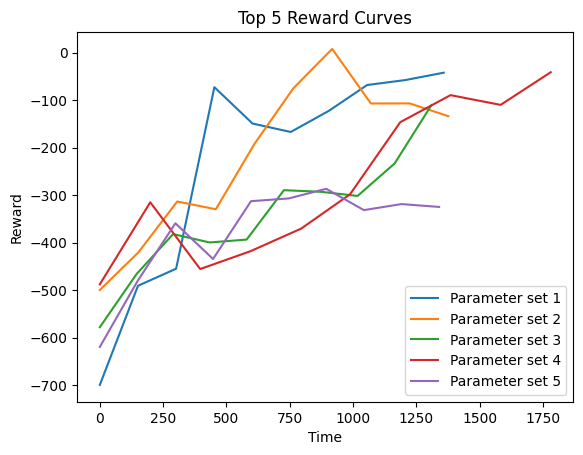

In [ ]:
# prompt: top_5를 시각화 해줘

# Import necessary libraries
import matplotlib.pyplot as plt

# Extract reward lists and time lists from results
reward_lists = [result[0] for result in results]
time_lists = [result[1] for result in results]

time_lists_new = [[time - time_list[0] for time in time_list] for time_list in time_lists]

# Select the top 5 reward lists and time lists
top_5_reward_lists = [reward_lists[i] for i in top_5_indices]
top_5_time_lists = [time_lists_new[i] for i in top_5_indices]

# Plot the top 5 reward curves
for i in range(len(top_5_reward_lists)):
    plt.plot(top_5_time_lists[i], top_5_reward_lists[i], label=f"Parameter set {i + 1}")

# Add labels and legend
plt.xlabel("Time")
plt.ylabel("Reward")
plt.title("Top 5 Reward Curves")
plt.legend()

# Show the plot
plt.show()
